# Week 4 Assignment

## Summary:

In this week's assignment, I will use the 20 News Groups dataset to build two classifier models. The dataset contains 20 topic categories for posts within a news group, with a set of training and test data. During the text processing stage I removed the newline from the posts, and then using the `cleanCorpus` function from previous assignments, I modified the code by removing the stemming feature, so that the language of the posts would stay more natural when being analyzed.

In [1]:
import numpy as np
import pandas as pd
import string
import matplotlib.pyplot as plt
import seaborn as sns
import plotly_express as px

from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords

from wordcloud import WordCloud

en_stopwords = stopwords.words('english')  
stopwords = set(en_stopwords)

%matplotlib inline

In [2]:
#load the sample 20 News Groups dataset
#assign the training and test data to variables
ng_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))

ng_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))

In [3]:
#see what items are included in the dataset package
ng_train.keys()

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])

In [4]:
#description of the dataset
print(ng_train['DESCR'])

.. _20newsgroups_dataset:

The 20 newsgroups text dataset
------------------------------

The 20 newsgroups dataset comprises around 18000 newsgroups posts on
20 topics split in two subsets: one for training (or development)
and the other one for testing (or for performance evaluation). The split
between the train and test set is based upon a messages posted before
and after a specific date.

This module contains two loaders. The first one,
:func:`sklearn.datasets.fetch_20newsgroups`,
returns a list of the raw texts that can be fed to text feature
extractors such as :class:`sklearn.feature_extraction.text.CountVectorizer`
with custom parameters so as to extract feature vectors.
The second one, :func:`sklearn.datasets.fetch_20newsgroups_vectorized`,
returns ready-to-use features, i.e., it is not necessary to use a feature
extractor.

**Data Set Characteristics:**

    =================   ==========
    Classes                     20
    Samples total            18846
    Dimensionality 

In [5]:
#there are 11,314 data points in this set
len(ng_train['data'])

11314

In [6]:
#check contents inside first item in training dataset
ng_train['data'][0]

'I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.'

In [7]:
#check contents inside third item in training dataset
ng_train['data'][3]

"\nDo you have Weitek's address/phone number?  I'd like to get some information\nabout this chip.\n"

In [8]:
#assign feature contents of training dataset to variable
ng_trainls = ng_train['data']

In [9]:
#verify the length of list [BEFORE]
len(ng_trainls)

11314

### Text Processing

The functions in this section take in a list of posts and replaces newlines that occur in the text with empty spaces instead. This creates a placeholder delimiter for when the `word_tokenize` function is used in the `cleanCorpus` function. Then with the data that is stripped of newlines, the `cleanCorpus` function is run and returns "Corpus is clean." when the process finishes. The training and test feature data, as well as the training and test target data are stored in variables for use during the modeling process.

In [10]:
#empty list to hold posts with newline removed
ngtr_nlr = []

for post in ng_trainls:
    clean_post = post.replace("\n", " ")
    ngtr_nlr.append(clean_post)

In [11]:
#verify same number of contents in list as before newline removal
#[AFTER]
len(ngtr_nlr)

11314

In [12]:
#verify the newlines are removed
ngtr_nlr[0]

'I was wondering if anyone out there could enlighten me on this car I saw the other day. It was a 2-door sports car, looked to be from the late 60s/ early 70s. It was called a Bricklin. The doors were really small. In addition, the front bumper was separate from the rest of the body. This is  all I know. If anyone can tellme a model name, engine specs, years of production, where this car is made, history, or whatever info you have on this funky looking car, please e-mail.'

In [13]:
#function to lowercase, remove punctuation/digits, tokenize (split into words), and remove stopwords
def cleanCorpus(corpus):
    
    clean_document = []
    
    for doc in corpus:
        
        #make all words lowercased
        lowercased = doc.lower()
        
        #remove punctuation and digits
        table = str.maketrans({key: None for key in string.punctuation + string.digits + "‘" + "’"})
        nopunct_digits = lowercased.translate(table)
        
        #make a list of word tokens
        tknzls = word_tokenize(nopunct_digits)
        
        #remove stopwords and then stem remaining words
        #cleanwls is a list
        cleanwls = []
        
        for token in tknzls:
            if token not in stopwords:
                
                cleanwls.append(token)
                
                
        #join list of cleaned words together into one string
        clean_str = " ".join(cleanwls)
        
        #add string as list item
        clean_document.append(clean_str)
    
    #confirmation that all documents are finished with text cleaning process
    print("Corpus is clean.")
    
    #returned output is a list with each document item from corpus as a string
    return clean_document

In [14]:
#run the cleanCorpus function on the newline removed training dataset
#cleaned training data 
#output is a list
clean_train = cleanCorpus(ngtr_nlr)

Corpus is clean.


In [15]:
#verify the contents after text processing
clean_train[0]

'wondering anyone could enlighten car saw day door sports car looked late early called bricklin doors really small addition front bumper separate rest body know anyone tellme model name engine specs years production car made history whatever info funky looking car please email'

In [16]:
#list of news group categories
ng_train['target_names']

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [17]:
#set list of target names to variable
category_names = ng_train['target_names']

In [18]:
#verify first item in the list
category_names [0]

'alt.atheism'

In [19]:
#create a dictionary to map target variable numbers to category name
categories = {}

#for each category in the list
for name in category_names:
    
    #index number will be key, category name will be value
    categories[category_names.index(name)] = name

In [20]:
#verify contents in dictionary
categories

{0: 'alt.atheism',
 1: 'comp.graphics',
 2: 'comp.os.ms-windows.misc',
 3: 'comp.sys.ibm.pc.hardware',
 4: 'comp.sys.mac.hardware',
 5: 'comp.windows.x',
 6: 'misc.forsale',
 7: 'rec.autos',
 8: 'rec.motorcycles',
 9: 'rec.sport.baseball',
 10: 'rec.sport.hockey',
 11: 'sci.crypt',
 12: 'sci.electronics',
 13: 'sci.med',
 14: 'sci.space',
 15: 'soc.religion.christian',
 16: 'talk.politics.guns',
 17: 'talk.politics.mideast',
 18: 'talk.politics.misc',
 19: 'talk.religion.misc'}

In [21]:
#store list of target variable for training data to new variable
ng_target = ng_train['target']

In [22]:
#assign test data to variable
ng_testls = ng_test['data']

In [23]:
#check first item in test data list
ng_testls[0]

'I am a little confused on all of the models of the 88-89 bonnevilles.\nI have heard of the LE SE LSE SSE SSEI. Could someone tell me the\ndifferences are far as features or performance. I am also curious to\nknow what the book value is for prefereably the 89 model. And how much\nless than book value can you usually get them for. In other words how\nmuch are they in demand this time of year. I have heard that the mid-spring\nearly summer is the best time to buy.'

In [24]:
#remove newlines from test data
ngts_nlr = []

for post in ng_testls:
    clean_post = post.replace("\n", " ")
    ngts_nlr.append(clean_post)

In [25]:
#use first item to verify newlines are removed
ngts_nlr[0]

'I am a little confused on all of the models of the 88-89 bonnevilles. I have heard of the LE SE LSE SSE SSEI. Could someone tell me the differences are far as features or performance. I am also curious to know what the book value is for prefereably the 89 model. And how much less than book value can you usually get them for. In other words how much are they in demand this time of year. I have heard that the mid-spring early summer is the best time to buy.'

In [26]:
#run the cleanCorpus function on the newline removed test dataset
#clean test data 
#output is a list
clean_test = cleanCorpus(ngts_nlr)

Corpus is clean.


***

### Classifer Models

For text classification, I focused on testing two models - a decision tree and Naive Bayes. I chose to test the decision tree because it is a simple model to implement and I chose Naive Bayes because it generally works well with text data. 

First, I built each model using the training set and generated a score. Then I passed through the test data and held the predictive results in a variable for evaluation using a classification report. Eahc model also had a score generated from the test data, as a metric of how well the model did compared to the actual test data categories.

#### Decision Tree

In [27]:
#initialize vectorizer
tfidf = TfidfVectorizer()

In [28]:
#transform corpus data into a matrix
#these are features used to predict (X)
#every column is a word
#every data point (row) is a document (news group post)
train_matrix = tfidf.fit_transform(clean_train)

In [29]:
#initialize decision tree model
tree = DecisionTreeClassifier()

In [30]:
#set target values of training set in variable
#this is the "y"
train_target = ng_train['target']

In [31]:
#build decision tree model with training data
tree.fit(train_matrix,train_target)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [32]:
#score of decision tree model with training data
tree.score(train_matrix, train_target)

0.973926109245183

In [33]:
#set target values of test data in variable
#this is the "y"
test_target = ng_test['target']

In [34]:
#create matrix of test data
#these are features used to predict (X)
#columns are words
#rows are documents (posts)
test_matrix = tfidf.transform(clean_test)

In [35]:
#generate predictive output of decision tree model
#output is a list
dt_test_pred = tree.predict(test_matrix)

In [36]:
#score of decision tree model on test data
tree.score(test_matrix, test_target)

0.4198088157195964

In [37]:
#predictive scores from decision tree model by category
print(classification_report(test_target, dt_test_pred, target_names=category_names))

                          precision    recall  f1-score   support

             alt.atheism       0.27      0.24      0.26       319
           comp.graphics       0.40      0.40      0.40       389
 comp.os.ms-windows.misc       0.42      0.40      0.41       394
comp.sys.ibm.pc.hardware       0.38      0.36      0.37       392
   comp.sys.mac.hardware       0.42      0.42      0.42       385
          comp.windows.x       0.48      0.41      0.44       395
            misc.forsale       0.55      0.55      0.55       390
               rec.autos       0.26      0.53      0.35       396
         rec.motorcycles       0.64      0.54      0.59       398
      rec.sport.baseball       0.56      0.47      0.51       397
        rec.sport.hockey       0.56      0.59      0.57       399
               sci.crypt       0.55      0.45      0.50       396
         sci.electronics       0.29      0.30      0.30       393
                 sci.med       0.46      0.39      0.42       396
         

#### Naive Bayes

In [38]:
#initialize Multinominal Naive Bayes model
naivebayes = MultinomialNB()

In [39]:
#build Naive Bayes model using training data
#will learn the patterns/trends
naivebayes.fit(train_matrix,train_target)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [40]:
#score of Naive Bayes model on training set
naivebayes.score(train_matrix,train_target)

0.8671557362559661

In [41]:
#generate predictive output from Naive Bayes model
nb_test_pred = naivebayes.predict(test_matrix)

In [42]:
#score of Naive Bayes model on test data
naivebayes.score(test_matrix, test_target)

0.6563993627190653

In [43]:
#predictive scores from Naive Bayes model by category
print(classification_report(test_target, nb_test_pred, target_names=category_names))

                          precision    recall  f1-score   support

             alt.atheism       0.77      0.14      0.24       319
           comp.graphics       0.66      0.63      0.64       389
 comp.os.ms-windows.misc       0.70      0.57      0.63       394
comp.sys.ibm.pc.hardware       0.56      0.72      0.63       392
   comp.sys.mac.hardware       0.75      0.63      0.69       385
          comp.windows.x       0.78      0.75      0.76       395
            misc.forsale       0.80      0.71      0.76       390
               rec.autos       0.84      0.71      0.77       396
         rec.motorcycles       0.84      0.75      0.79       398
      rec.sport.baseball       0.93      0.79      0.85       397
        rec.sport.hockey       0.58      0.93      0.71       399
               sci.crypt       0.53      0.80      0.64       396
         sci.electronics       0.71      0.50      0.59       393
                 sci.med       0.87      0.72      0.79       396
         

***

### Data Visualization

As an exploratory analysis, I created a pandas dataframe with the training dataset of the text and categories as columns. The dataframe was used to plot a bar chart for the frequency of each post category, and also generate a word cloud from the most prominent (frequent) words within each category.

After the text classification, I converted each model's classification report into a dataframe and used it to create a scatterplot to compare the precision and recall scrores by category. Finally, I compared the precision and recall scores just between the two different models in ordet to evaluate their overall performance against each other using the same data.

In [44]:
#map together index positions of training features data and target variable
#compile into one list (with two lists as items)
fetch20_data = list(zip(clean_train, train_target))

In [45]:
#make training data list into dataframe
fetch20df = pd.DataFrame(fetch20_data, columns=['data', 'target'])

In [46]:
#add new column to hold string value of category name
#created using category number mapped from dictionary
fetch20df['target_cat'] = fetch20df['target'].map(categories)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text xticklabel objects>)

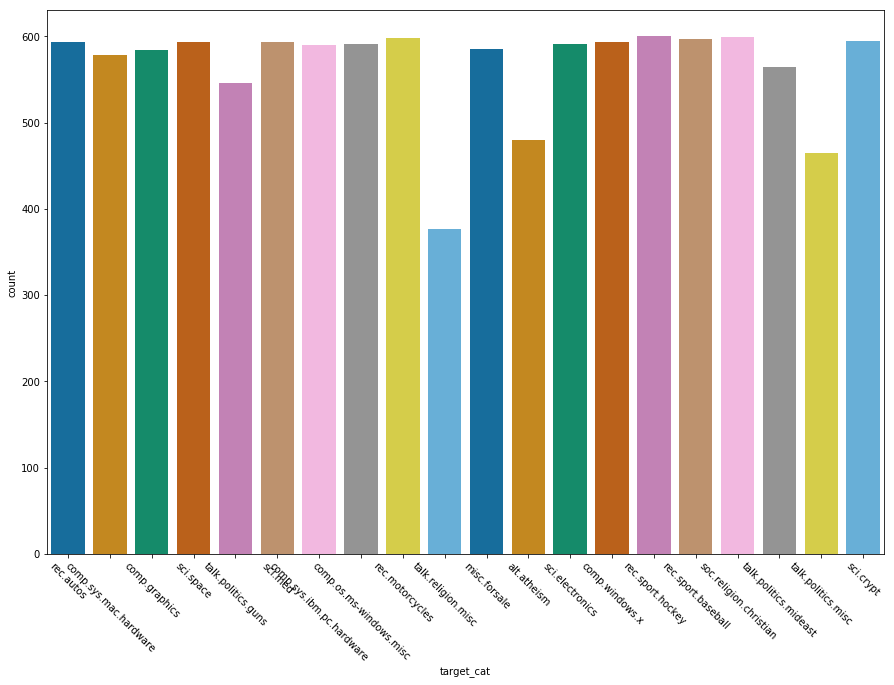

In [47]:
#number of posts in training by category
plt.figure(figsize=(15,10))

sns.countplot(x='target_cat', data=fetch20df, palette='colorblind')

plt.xticks(rotation=-45)

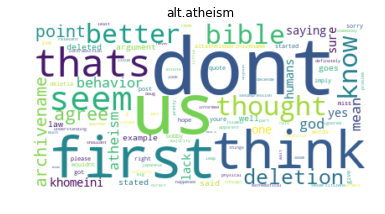

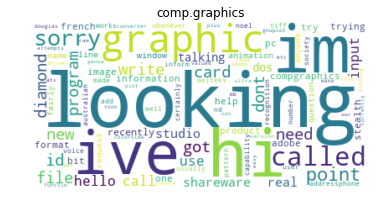

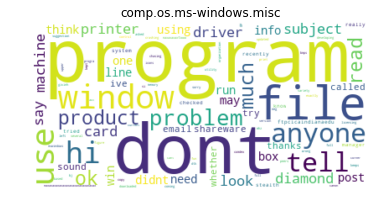

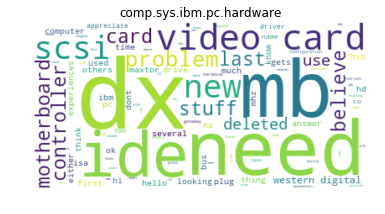

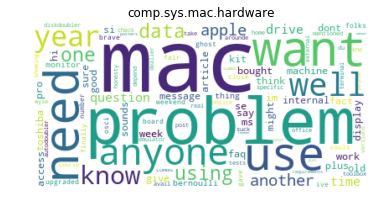

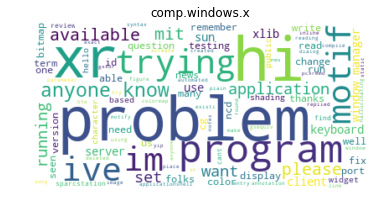

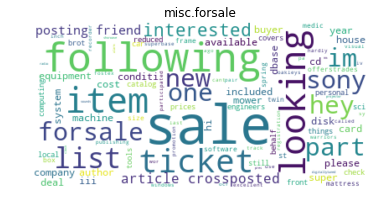

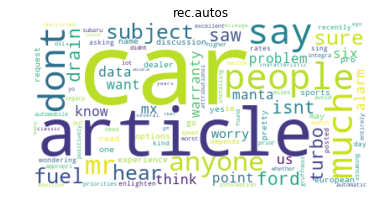

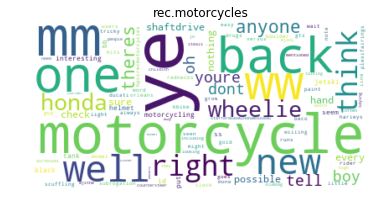

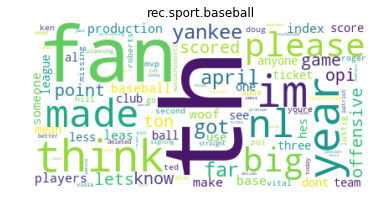

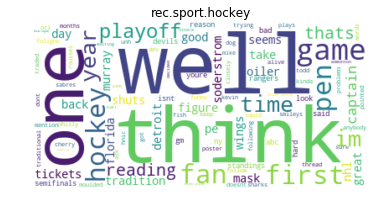

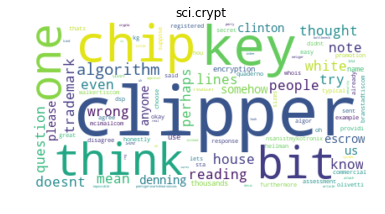

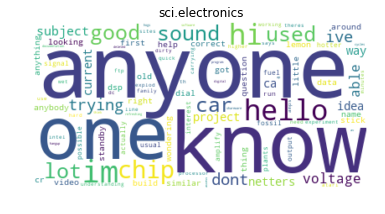

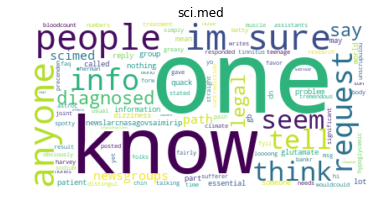

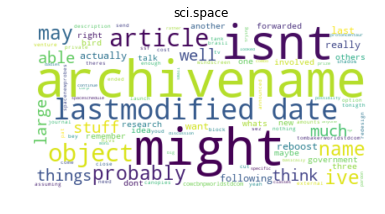

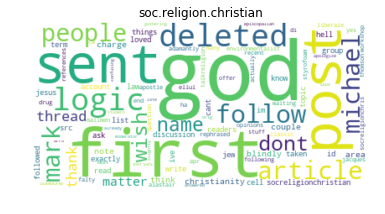

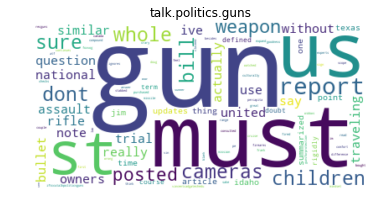

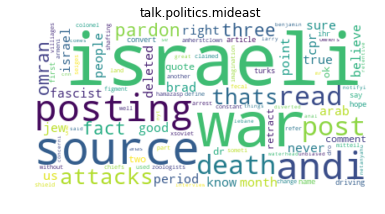

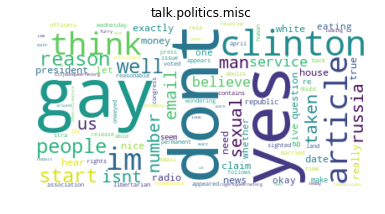

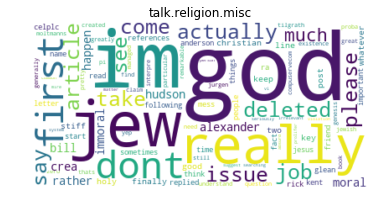

In [48]:
#make dataframes of all data points for each category
#use that dataframe to create word cloud for category

for category in category_names:
    
    #category name is a string
    df = fetch20df.loc[fetch20df['target_cat'] == category]
    
    wordcloud = WordCloud(background_color="white", max_words=100).generate(str(df['data']))
    plt.figure()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(category)
    plt.show()

In [49]:
#make decision tree classification report into a dataframe
#flip columns to be rows and vice versa
dt_report = classification_report(test_target, dt_test_pred, output_dict=True)
dt_cr_df = pd.DataFrame(dt_report).transpose()

In [50]:
#take only first 20 rows from dataframe
#bottom of original df contained overall score averages
dt_cr_df = dt_cr_df.iloc[:20]
dt_cr_df

,f1-score,precision,recall,support
0,0.256240,0.273050,0.241379,319.0
1,0.399488,0.397959,0.401028,389.0
2,0.409794,0.416230,0.403553,394.0
3,0.368421,0.380435,0.357143,392.0
4,0.417755,0.419948,0.415584,385.0
5,0.442019,0.479290,0.410127,395.0
6,0.551546,0.554404,0.548718,390.0
7,0.346535,0.257353,0.530303,396.0
8,0.586630,0.641791,0.540201,398.0
9,0.510989,0.561934,0.468514,397.0


In [51]:
#add a column for category names
dt_cr_df['cat_names'] = category_names

#label all rows with Decision Tree classfier type
dt_cr_df['classifier'] = 'Decision Tree'

In [52]:
#output of decision tree dataframe
dt_cr_df

,f1-score,precision,recall,support,cat_names,classifier
0,0.256240,0.273050,0.241379,319.0,alt.atheism,Decision Tree
1,0.399488,0.397959,0.401028,389.0,comp.graphics,Decision Tree
2,0.409794,0.416230,0.403553,394.0,comp.os.ms-windows.misc,Decision Tree
3,0.368421,0.380435,0.357143,392.0,comp.sys.ibm.pc.hardware,Decision Tree
4,0.417755,0.419948,0.415584,385.0,comp.sys.mac.hardware,Decision Tree
5,0.442019,0.479290,0.410127,395.0,comp.windows.x,Decision Tree
6,0.551546,0.554404,0.548718,390.0,misc.forsale,Decision Tree
7,0.346535,0.257353,0.530303,396.0,rec.autos,Decision Tree
8,0.586630,0.641791,0.540201,398.0,rec.motorcycles,Decision Tree
9,0.510989,0.561934,0.468514,397.0,rec.sport.baseball,Decision Tree


Text(0.5,1,'Decision Tree: Precision vs Recall')

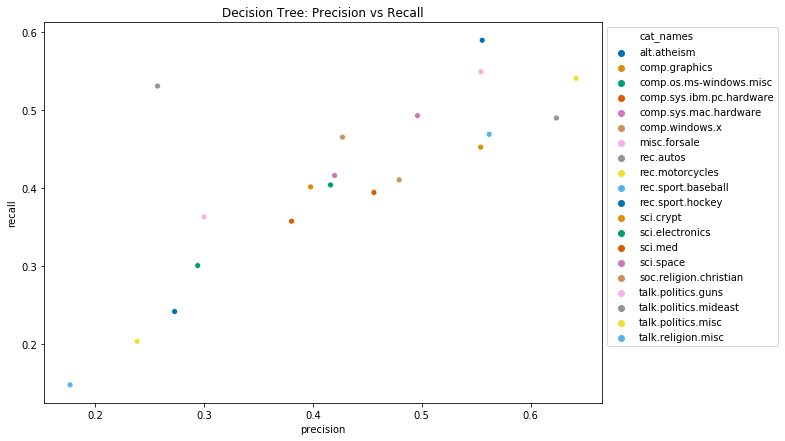

In [53]:
#plot comparison of precision & recall scores from decision tree model
plt.figure(figsize=(10,7))

sns.scatterplot(data=dt_cr_df, x='precision', y='recall' , hue='cat_names', palette="colorblind")
plt.legend(bbox_to_anchor=(1,1), loc=2)
plt.title("Decision Tree: Precision vs Recall")

In [54]:
#make Naive Bayes classification report into a dataframe
#flip columns to be rows and vice versa
nb_report = classification_report(test_target, nb_test_pred, output_dict=True)
nb_cr_df = pd.DataFrame(nb_report).transpose()

In [55]:
#take only first 20 rows from dataframe
#bottom of original df contained overall score averages
nb_cr_df = nb_cr_df.iloc[:20]
nb_cr_df

,f1-score,precision,recall,support
0,0.242744,0.766667,0.144201,319.0
1,0.644737,0.660377,0.629820,389.0
2,0.626573,0.697819,0.568528,394.0
3,0.630411,0.557957,0.724490,392.0
4,0.686441,0.752322,0.631169,385.0
5,0.763260,0.780423,0.746835,395.0
6,0.755435,0.803468,0.712821,390.0
7,0.771546,0.841791,0.712121,396.0
8,0.788845,0.836620,0.746231,398.0
9,0.854817,0.926471,0.793451,397.0


In [56]:
#add a column for category names
nb_cr_df['cat_names'] = category_names

#label all rows with Niave Bayes classfier type
nb_cr_df['classifier'] = 'Naive Bayes'

In [57]:
#output of Naive Bayes dataframe
nb_cr_df

,f1-score,precision,recall,support,cat_names,classifier
0,0.242744,0.766667,0.144201,319.0,alt.atheism,Naive Bayes
1,0.644737,0.660377,0.629820,389.0,comp.graphics,Naive Bayes
2,0.626573,0.697819,0.568528,394.0,comp.os.ms-windows.misc,Naive Bayes
3,0.630411,0.557957,0.724490,392.0,comp.sys.ibm.pc.hardware,Naive Bayes
4,0.686441,0.752322,0.631169,385.0,comp.sys.mac.hardware,Naive Bayes
5,0.763260,0.780423,0.746835,395.0,comp.windows.x,Naive Bayes
6,0.755435,0.803468,0.712821,390.0,misc.forsale,Naive Bayes
7,0.771546,0.841791,0.712121,396.0,rec.autos,Naive Bayes
8,0.788845,0.836620,0.746231,398.0,rec.motorcycles,Naive Bayes
9,0.854817,0.926471,0.793451,397.0,rec.sport.baseball,Naive Bayes


Text(0.5,1,'Naive Bayes: Precision vs Recall')

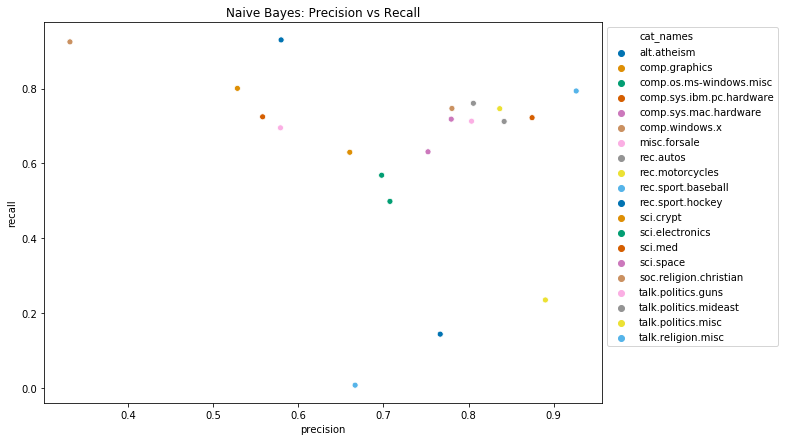

In [58]:
#plot comparison of precision & recall in Naive Bayes model
plt.figure(figsize=(10,7))

sns.scatterplot(data=nb_cr_df, x='precision', y='recall' , hue='cat_names', palette="colorblind")
plt.legend(bbox_to_anchor=(1,1), loc=2)
plt.title("Naive Bayes: Precision vs Recall")

In [59]:
#dataframe of all scores for both models (decision tree & Naive Bayes)
#attach rows of Naive Bayes dataframe to decision tree dataframe
allscores = dt_cr_df.append(nb_cr_df, ignore_index=True)

In [60]:
#verify dataframe was created
allscores

,f1-score,precision,recall,support,cat_names,classifier
0,0.256240,0.273050,0.241379,319.0,alt.atheism,Decision Tree
1,0.399488,0.397959,0.401028,389.0,comp.graphics,Decision Tree
2,0.409794,0.416230,0.403553,394.0,comp.os.ms-windows.misc,Decision Tree
3,0.368421,0.380435,0.357143,392.0,comp.sys.ibm.pc.hardware,Decision Tree
4,0.417755,0.419948,0.415584,385.0,comp.sys.mac.hardware,Decision Tree
5,0.442019,0.479290,0.410127,395.0,comp.windows.x,Decision Tree
6,0.551546,0.554404,0.548718,390.0,misc.forsale,Decision Tree
7,0.346535,0.257353,0.530303,396.0,rec.autos,Decision Tree
8,0.586630,0.641791,0.540201,398.0,rec.motorcycles,Decision Tree
9,0.510989,0.561934,0.468514,397.0,rec.sport.baseball,Decision Tree


Text(0.5,1,'Model Evaluation: Decision Tree vs Naive Bayes')

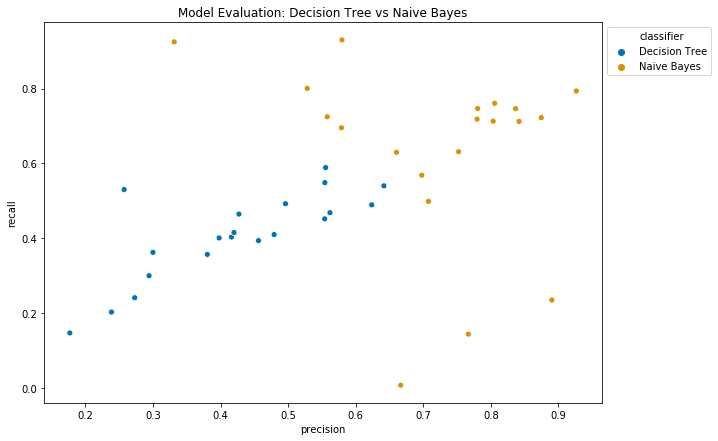

In [61]:
#plot comparison of precision & recall scores of both models

plt.figure(figsize=(10,7))

sns.scatterplot(data=allscores, x='precision', y='recall' , hue='classifier', palette="colorblind")
plt.legend(bbox_to_anchor=(1,1), loc=2)
plt.title("Model Evaluation: Decision Tree vs Naive Bayes")

### Conclusion:

In the visual EDA section, topics that are usually sensitive/controversial had the strongest word themes that stood out in the generated word cloud. These topics include religion and politics, but it was also a bit noteworthy that the mac and windows topics seem to have a lot of people talking/asking about a problem which is probably related to issues with their computer, so they use this newsgroup to crowdsource advice. Also, from the bar chart of the number of items per category, miscellaneous religion had the lowest amount of data points to use to train the models which reflects in the classification model scatterplots. This category has low precision and recall in the decision tree model, and low recall in the Naive Bayes model.

In the Model Evaluation scatterplot, it is evident that the Naive Bayes model performed much better on the data than the decision tree model, as seen by the high precision and recall scores on about half of the dataset. Looking back at the test data scores of each model, Naive Bayes performed at ~66% compared to the decision tree model with ~42%, even though the decision tree model scored better during training. In future iterations of this analysis, I could go back to the data and further process it, possibly using stemming on the text to see if the models perform better or worse.